In [521]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm as t
from scipy import ndimage
    

#Change lines below to match name of the directory and names of the files

data_dir = "/home/pau/Documents/DataHotIPs/"
namefile = lambda i,j: data_dir + 'source_'+str(i)+'_'+str(j)+'.npy'
    

#Parameters of the grid
Ntimes = 119
N = 80

In [522]:
true_source = (3,7)

In [523]:
N_sensors = 100
sensors = np.zeros((N_sensors, 2))
while len(np.unique(sensors, axis = 0)) < N_sensors:
    sensors = np.random.randint(0,N, size = (N_sensors, 2))

measurement_array = np.zeros((Ntimes, N, N)).astype(bool)
#sensors = [[6*i, 6*i] for i in range(1,11)]
n_measurements = 0
for i in range(Ntimes):
    for sensor in sensors:
        measurement_array[i, sensor[0], sensor[1]] = True
        n_measurements +=1

In [524]:
def tanteo(K):
    "Finds an alpha such that 0 < np.sum(np.exp(K+alpha) < ∞"
    i = -np.max(K)
    while np.sum(np.exp(K+i)) == 0:
        i+=10
        print(i)
    while np.sum(np.exp(K+i)) == np.inf:
        i-=1
        print(i)
    return i

In [525]:
def compute_posterior(true_source, measurement_array, sigma):

    #An example of precomputed measurements #Depends only on the measurement_array
    precomputed_measurements = np.zeros((N,N,n_measurements))
    for i in t(range(N)):
        for j in range(N):
            precomputed_measurements[i,j] = np.load(namefile(i,j), mmap_mode = 'r')[measurement_array]

    #Example uniform prior
    prior = 1/N**2 * np.ones((N,N))

    True_measurements = np.load(namefile(*true_source))[measurement_array]
    #sigma = 1e1
    #noise = np.random.multivariate_normal(mean = [0]*n_measurements, cov = Sigma_noise)
    noise = np.array([np.random.normal(scale = sigma) for i in range(n_measurements)])
    data = True_measurements + noise

    posterior = np.zeros((N,N))
    #sigma = 1e-1
    #I'm not sure if this can be vectorized anymore since I have to individually open and close files
    #However, it is not slow
    for i in t(range(N)):
        for j in range(N):
            #Compute prob(data|source is in (i,j))
            #Compute first true observations that would have happened if the source was in (i,j)
            hypothetical_observations = precomputed_measurements[i,j]
            posterior[i,j] = (-1/(2 * sigma**2) * np.linalg.norm(data-hypothetical_observations)**2)
    #s = np.sum(posterior)
    #posterior/= s

    K = posterior + np.log(prior)

    print(tanteo(K), -np.max(K))
    
    def f(alpha):
        return (np.sum(np.exp(K+alpha)) - 1)**2
    
    sol = minimize(f, tanteo(K))
    print(sol.message, sol.fun, sol.x)
    true_post = np.exp(K+sol.x)
    return true_post#, ndimage.center_of_mass(true_post)

In [515]:
post = compute_posterior(measurement_array = measurement_array, true_source = (2,3), sigma = 0.001)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

3000.496789184663 3000.496789184663
Optimization terminated successfully. 1.9724724324428455e-14 [2999.8776797]


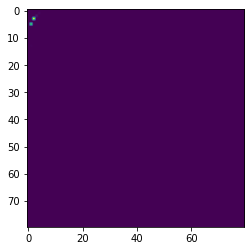

In [519]:
plt.imshow(post)

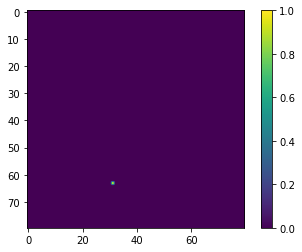

In [518]:
plt.imshow(np.exp(K+sol.x))
plt.colorbar()

In [35]:
def weighted_norm(Sigma_inv, x):
    return x.T@Sigma_inv@x

def compute_posterior(prior, true_source, measurement_array, Sigma_noise, preload_data = None, preload_measurements = None):

    if preload_data is None:
        #Generate random data
        True_measurements = np.load(namefile(*true_source))[measurement_array]
        noise = np.random.multivariate_normal(mean = [0]*n_measurements, cov = Sigma_noise)
        data = True_measurements + noise
    else: 
        data = preload_data
    
    if preload_measurements is None:
        #Will load the matrices from disk
        get_measurements = lambda i,j: np.load(namefile(i,j))[measurement_array]
    else:
        #Measurements has to be (N,N,N_measurements)
        get_measurements = lambda i,j: preload_measurements[i,j]
  
    
    Sigma_inv = np.linalg.inv(Sigma_noise)
    posterior = np.zeros((N,N))
    #I'm not sure if this can be vectorized anymore since I have to individually open and close files
    #However, it is not slow
    for i in t(range(N)):
        for j in range(N):
            #Compute prob(data|source is in (i,j))
            #Compute first true observations that would have happened if the source was in (i,j)
            hypothetical_observations = get_measurements(i,j)
            posterior[i,j] = prior[i,j]*np.exp(-1/2 * weighted_norm(Sigma_inv, data-hypothetical_observations))
    s = np.sum(posterior)
    posterior/= s
    return posterior

In [33]:
sigma = 0.01 
Sigma_noise = sigma**2*np.eye(n_measurements) #Assuming here that all the sensors are independent and with the same noise

In [36]:
posterior = compute_posterior(prior = prior, true_source=true_source, measurement_array=measurement_array, Sigma_noise=Sigma_noise, 
                 preload_measurements= precomputed_measurements, preload_data = data)

  0%|          | 0/80 [00:00<?, ?it/s]

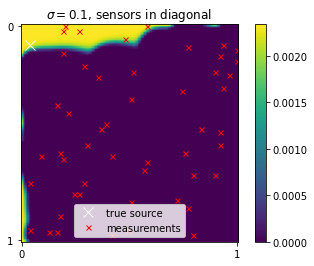

In [37]:
plt.imshow(posterior)
plt.title(r'$\sigma=0.1$, sensors in diagonal')
plt.plot([3],[7],'x', color = 'white', markersize = 10, label = 'true source')
plt.plot(*np.array(sensors).T, 'x', color = 'red', markersize = 5, label = 'measurements')
plt.xticks([0,79], [0,1])
plt.yticks([0,79], [0,1])

plt.colorbar()
plt.legend()

  0%|          | 0/80 [00:00<?, ?it/s]

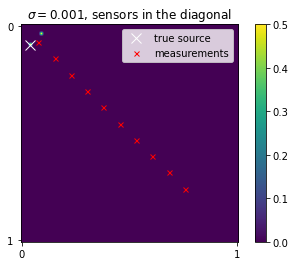

  0%|          | 0/80 [00:00<?, ?it/s]

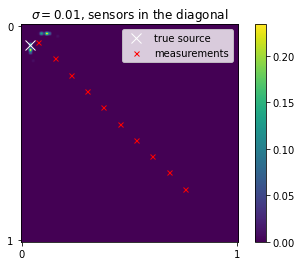

  0%|          | 0/80 [00:00<?, ?it/s]

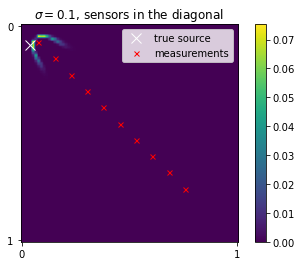

  0%|          | 0/80 [00:00<?, ?it/s]

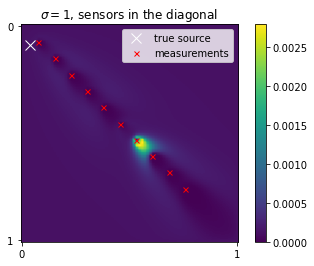

In [48]:

for num, sigma in enumerate([0.001, 0.01, 0.1, 1]):

    posterior = compute_posterior(prior = prior, true_source=true_source, measurement_array=measurement_array, 
                                  Sigma_noise=sigma**2*np.eye(n_measurements), preload_measurements= precomputed_measurements)
    plt.imshow(posterior)
    plt.title(r'$\sigma='+str(sigma)+'$, sensors in the diagonal')
    plt.plot([3],[7],'x', color = 'white', markersize = 10, label = 'true source')
    plt.plot(*np.array(sensors).T, 'x', color = 'red', markersize = 5, label = 'measurements')
    plt.xticks([0,79], [0,1])
    plt.yticks([0,79], [0,1])
    plt.colorbar()
    plt.legend()
    plt.show()